# Probabilistic Programming 3: Regression & Classification

#### Goal 
  - Understand how to estimate regression parameters using Bayesian inference.
  - Understand how to estimate classification parameters using Bayesian inference.
  
#### Materials       
  - Mandatory
    - This notebook.
    - Lecture notes on [regression](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Regression.ipynb).
    - Lecture notes on [discriminative classification](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Discriminative-Classification.ipynb).
  - Optional
    - Bayesian linear regression (Section 3.3 [Bishop](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf))
    - Bayesian logistic regression (Section 4.5 [Bishop](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf))
    - Local Variational Methods (Section 10.5 [Bishop](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf))
    - [Cheatsheets: how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

In [1]:
using Pkg
Pkg.activate("workspace")
Pkg.instantiate();
IJulia.clear_output();

## Problem: Economic growth

In 2008, the credit crisis sparked a recession in the US, which spread to other countries in the ensuing years. It took most countries a couple of years to recover. 
Now, the year is 2011. The Turkish government is asking you to estimate whether Turkey is out of the recession. You decide to look at the data of the national stock exchange to see if there's a positive trend. 

In [2]:
using CSV
using DataFrames
using ProgressMeter
using Plots
pyplot();

### Data

We are going to start with loading in a data set. We have daily measurements from Istanbul, from the 5th of January 2009 until 22nd of February 2011. The dataset comes from an online resource for machine learning data sets: the [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE).

In [3]:
# Read CSV file
df = CSV.read("../datasets/istanbul_stockexchange.csv")

,date,ISE
,String,Float64
1,5-Jan-09,0.0357537
2,6-Jan-09,0.0254259
3,7-Jan-09,-0.0288617
4,8-Jan-09,-0.0622081
5,9-Jan-09,0.00985991
6,12-Jan-09,-0.029191
7,13-Jan-09,0.0154453
8,14-Jan-09,-0.0411676
9,15-Jan-09,0.000661905


We can plot the evolution of the stock market values over time.

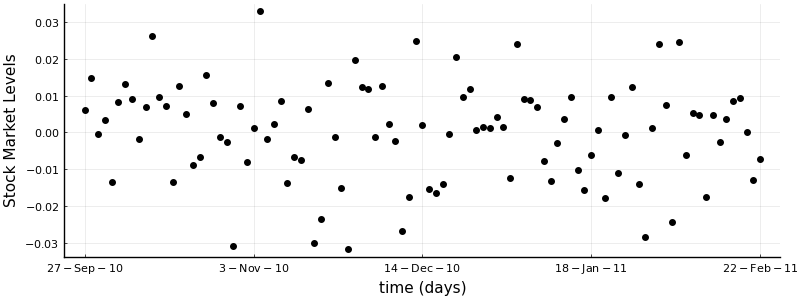

In [4]:
# Count number of samples
time_period = 436:536
num_samples = length(time_period)

# Extract columns
dates_num = 1:num_samples
dates_str = df[time_period,1]
stock_val = df[time_period,2]

# Set xticks
xtick_points = Int64.(round.(range(1, stop=num_samples, length=5)))

# Scatter exchange levels
scatter(dates_num, 
        stock_val, 
        color="black",
        label="", 
        ylabel="Stock Market Levels", 
        xlabel="time (days)",
        xticks=(xtick_points, [dates_str[i] for i in xtick_points]), 
        size=(800,300))

### Model specification

We have dates $X$, referred to as "covariates", and stock exchange levels $Y$, referred to as "responses". A regression model has parameters $\theta$, used to predict $Y$ from $X$. We are looking for a posterior distribution for the parameters $\theta$:

$$\underbrace{p(\theta \mid Y, X)}_{\text{posterior}} \propto\ \underbrace{p(Y \mid X, \theta)}_{\text{likelihood}} \cdot \underbrace{p(\theta)}_{\text{prior}}$$

We assume each observation $Y_i$ is generated via: 

$$ Y_i = f_\theta(X_i) + e$$ 

where $e$ is white noise, $e \sim \mathcal{N}(0, \sigma^2_Y)$, and the regression function $f_\theta$ is linear: $f_\theta(X) = X \theta_1 + \theta_2$. The parameters consist of a slope coefficient $\theta_1$ and an intercept $\theta_2$, which are summarized into a parameter vector, $\theta = \begin{bmatrix}\theta_1 \\ \theta_2 \end{bmatrix}$. In practice, we augment the data matrix X with a 1, i.e., $\begin{bmatrix}X \\ 1 \end{bmatrix}$, so that we may define $f_\theta(X) = \theta^{\top}X$. 

If we integrate out the noise $e$, then we obtain a Gaussian likelihood function centered on $f_\theta(X)$ with variance $\sigma^2_Y$:

$$Y_i \sim \mathcal{N}(f_\theta(X_i),\sigma^2_Y)\, \ .$$ 

Note that this corresponds to $p(Y \mid X, \theta)$. We know that the weights are real numbers and that they can be negative. That motivates us to use a Gaussian prior:

$$ \theta \sim \mathcal{N}(\mu_\theta, \sigma^2_\theta) \, .$$

Note that this corresponds to $p(\theta)$. For now, this is all we need. We're going to specify these two equations with ForneyLab. Our prior will become the first factor node: $f_a(\theta) = \mathcal{N}(\theta \mid \mu_\theta, \sigma^2_\theta)$ and our likelihood becomes the second factor node $f_b(\theta) = \mathcal{N}(f_\theta(X_i),\sigma^2_Y)$. Note that $\theta$ is the only unknown variable, since $X$ and $Y$ are observed and $\mu_\theta$, $\sigma^2_\theta$ and $\sigma^2_Y$ are clamped.

In [5]:
using ForneyLab

In [6]:
# Start factor graph
graph = FactorGraph();

# Prior weight parameters
μ_θ = [0., 0.]
σ2_θ = [1. 0.; 0. 1.]

# Noise variance
σ2_Y = 1.

# Add weight prior to graph
@RV θ ~ GaussianMeanVariance(μ_θ, σ2_θ, id=:f_a)
    
# Define covariates
@RV X

# Define likelihood
@RV Y ~ GaussianMeanVariance(dot(θ,X), σ2_Y, id=:f_b)

# Designate observed variables
placeholder(X, :X, dims=(2,))
placeholder(Y, :Y)

# Visualise the graph
ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 9069357023086573837 -->
 
 9069357023086573837 
 
 clamp_1 
 
<!-- 14287884337452920672 -->
 
 14287884337452920672 
 
 dot 
 dotproduct_1 
 
<!-- 12926103398095740267 -->
 
 12926103398095740267 
 
 𝒩 
 f_a 
 
<!-- 14287884337452920672--12926103398095740267 -->
 
 14287884337452920672--12926103398095740267 
 
 θ 
 1 out 
 3 in2 
 
<!-- 13698349073181286090 -->
 
 13698349073181286090 
 
 placeholder_Y 
 
<!-- 13521377324838095454 -->
 
 13521377324838095454 
 
 𝒩 
 f_b 
 
<!-- 13698349073181286090--13521377324838095454 -->
 
 13698349073181286090--13521377324838095454 
 
 Y 
 1 out 
 1 out 
 
<!-- 13521377324838095454--14287884337452920672 -->
 
 13521377324838095454--14287884337452920672 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 4315071405241762853 -->
 
 4315071405241762853 
 
 clamp_3 
 
<!-- 13521377324838095454--4315071405241762853 -->
 
 13521377324838095454--4315071405241762853 
 
 clamp_3 
 1 out 
 3 v 
 
<!-- 9628824604399885747 -->
 
 9628824604399885747 
 
 clamp_2 
 
<!-- 6872823434522960768 -->
 
 6872823434522960768 
 
 placeholder_X 
 
<!-- 6872823434522960768--14287884337452920672 -->
 
 6872823434522960768--14287884337452920672 
 
 X 
 2 in1 
 1 out 
 
<!-- 12926103398095740267--9069357023086573837 -->
 
 12926103398095740267--9069357023086573837 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 12926103398095740267--9628824604399885747 -->
 
 12926103398095740267--9628824604399885747 
 
 clamp_2 
 1 out 
 3 v

But this is the graph for a single observation. In reality, we have multiple observations. If we want to consume all this information at once, the likelihood part of the above graph will need to be repeated.

In [7]:
# Start factor graph
graph2 = FactorGraph();

# Prior weight parameters
μ_θ = [0., 0.]
σ2_θ = [1. 0.; 0. 1.]

# Noise variance
σ2_Y = 1.

# Add weight prior to graph
@RV θ ~ GaussianMeanVariance(μ_θ, σ2_θ, id=:f_a)

# Pre-define vectors for storing latent and observed variables
X = Vector{Variable}(undef, num_samples) 
Y = Vector{Variable}(undef, num_samples)

for i = 1:num_samples
    
    # Define i-th covariate
    @RV X[i]
    
    # Define likelihood of i-th response
    @RV Y[i] ~ GaussianMeanVariance(dot(θ,X[i]), σ2_Y, id=Symbol("f_b"*string(i)))

    # Designate observed variables
    placeholder(X[i], :X, index=i, dims=(2,))
    placeholder(Y[i], :Y, index=i);
    
end

# Visualise the graph
ForneyLab.draw(graph2)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 7691338112986289479 -->
 
 7691338112986289479 
 
 = 
 equ_θ_28 
 
<!-- 11806383636677886390 -->
 
 11806383636677886390 
 
 dot 
 dotproduct_28 
 
<!-- 7691338112986289479--11806383636677886390 -->
 
 7691338112986289479--11806383636677886390 
 
 θ 
 3 in2 
 1 1 
 
<!-- 27706598126187400 -->
 
 27706598126187400 
 
 = 
 equ_θ_27 
 
<!-- 7691338112986289479--27706598126187400 -->
 
 7691338112986289479--27706598126187400 
 
 θ 
 3 3 
 2 2 
 
<!-- 608840068956741168 -->
 
 608840068956741168 
 
 𝒩 
 f_b57 
 
<!-- 1570989565641297737 -->
 
 1570989565641297737 
 
 dot 
 dotproduct_57 
 
<!-- 608840068956741168--1570989565641297737 -->
 
 608840068956741168--1570989565641297737 
 
 variable_57 
 1 out 
 2 m 
 
<!-- 982462173484892295 -->
 
 982462173484892295 
 
 clamp_59 
 
<!-- 608840068956741168--982462173484892295 -->
 
 608840068956741168--982462173484892295 
 
 clamp_59 
 1 out 
 3 v 
 
<!-- 11906931410989629200 -->
 
 11906931410989629200 
 
 𝒩 
 f_b26 
 
<!-- 4520138741388669418 -->
 
 4520138741388669418 
 
 dot 
 dotproduct_26 
 
<!-- 11906931410989629200--4520138741388669418 -->
 
 11906931410989629200--4520138741388669418 
 
 variable_26 
 1 out 
 2 m 
 
<!-- 9585784543334361991 -->
 
 9585784543334361991 
 
 clamp_28 
 
<!-- 11906931410989629200--9585784543334361991 -->
 
 11906931410989629200--9585784543334361991 
 
 clamp_28 
 1 out 
 3 v 
 
<!-- 15833964889563303969 -->
 
 15833964889563303969 
 
 clamp_34 
 
<!-- 11897359896145050549 -->
 
 11897359896145050549 
 
 clamp_78 
 
<!-- 17694523714227883150 -->
 
 17694523714227883150 
 
 clamp_4 
 
<!-- 8666806840132189638 -->
 
 8666806840132189638 
 
 𝒩 
 f_b42 
 
<!-- 9490693441225081902 -->
 
 9490693441225081902 
 
 clamp_44 
 
<!-- 8666806840132189638--9490693441225081902 -->
 
 8666806840132189638--9490693441225081902 
 
 clamp_44 
 1 out 
 3 v 
 
<!-- 2074153061290716462 -->
 
 2074153061290716462 
 
 dot 
 dotproduct_42 
 
<!-- 8666806840132189638--2074153061290716462 -->
 
 8666806840132189638--2074153061290716462 
 
 variable_42 
 1 out 
 2 m 
 
<!-- 17558258721109862201 -->
 
 17558258721109862201 
 
 𝒩 
 f_b19 
 
<!-- 7287127485615093198 -->
 
 7287127485615093198 
 
 dot 
 dotproduct_19 
 
<!-- 17558258721109862201--7287127485615093198 -->
 
 17558258721109862201--7287127485615093198 
 
 variable_19 
 1 out 
 2 m 
 
<!-- 15202227128334456358 -->
 
 15202227128334456358 
 
 clamp_21 
 
<!-- 17558258721109862201--15202227128334456358 -->
 
 17558258721109862201--15202227128334456358 
 
 clamp_21 
 1 out 
 3 v 
 
<!-- 9957169976902436542 -->
 
 9957169976902436542 
 
 clamp_101 
 
<!-- 68270055985754764 -->
 
 68270055985754764 
 
 = 
 equ_θ_74 
 
<!-- 656016167994119943 -->
 
 656016167994119943 
 
 = 
 equ_θ_73 
 
<!-- 68270055985754764--656016167994119943 -->
 
 68270055985754764--656016167994119943 
 
 θ 
 3 3 
 2 2 
 
<!-- 1680953104413390908 -->
 
 1680953104413390908 
 
 dot 
 dotproduct_74 
 
<!-- 68270055985754764--1680953104413390908 -->
 
 68270055985754764--1680953104413390908 
 
 θ 
 3 in2 
 1 1 
 
<!-- 17239144079107210827 -->
 
 17239144079107210827 
 
 placeholder_Y_80 
 
<!-- 17209176698375052949 -->
 
 17209176698375052949 
 
 𝒩 
 f_b80 
 
<!-- 17239144079107210827--17209176698375052949 -->
 
 17239144079107210827--17209176698375052949 
 
 Y_80 
 1 out 
 1 out 
 
<!-- 17846812001626887877 -->
 
 17846812001626887877 
 
 dot 
 dotproduct_6 
 
<!-- 13051647533759433964 -->
 
 13051647533759433964 
 
 placeholder_Y_91 
 
<!-- 2342900877494138092 -->
 
 2342900877494138092 
 
 𝒩 
 f_b91 
 
<!-- 13051647533759433964--2342900877494138092 -->
 
 13051647533759433964--2342900877494138092 
 
 Y_91 
 1 out 
 1 out 
 
<!-- 12082441203760595304 -->
 
 12082441203760595304 
 
 = 
 equ_θ_48 
 
<!-

It's hard to tell, but each of these likelihood nodes $f_{bi}$ is connected to the prior node $f_a$ via an equality node. 

Now that we have our model, it is time to infer parameters.

In [8]:
# Define and compile the algorithm
algorithm = messagePassingAlgorithm(θ) 
source_code = algorithmSourceCode(algorithm)

# Evaluate the generated code to get the step! function
eval(Meta.parse(source_code));
# println(source_code)

Now, we iterate over time, feeding our data as it comes in and updating our posterior distribution for the parameters.

In [9]:
# Initialize posterior 
posterior = Dict()

# Load i-th data point
data = Dict(:X => [[dates_num[i], 1] for i = 1:num_samples],
            :Y => stock_val)

# Update posterior for θ
step!(data, posterior);

Let's visualize the resulting posterior.

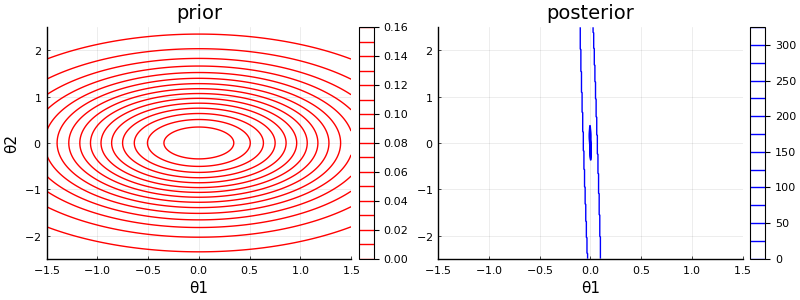

In [10]:
import ForneyLab: logPdf

# Define ranges for plot
x1 = range(-1.5, length=500, stop=1.5)
x2 = range(-2.5, length=500, stop=2.5)

# Draw contour plots of distributions
prior = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=μ_θ, v=σ2_θ)
p1a = contour(x1, x2, (x1,x2) -> exp(logPdf(prior, [x1,x2])), color="red", xlabel="θ1", ylabel="θ2", title="prior")
p1b = contour(x1, x2, (x1,x2) -> exp(logPdf(posterior[:θ], [x1,x2])), color="blue", xlabel="θ1", title="posterior")
plot(p1a, p1b, size=(800,300))

It has become quite sharply peaked in a small area of parameter space.

We can use the MAP point estimate to compute and visualize the regression function $f_\theta$. The full predictive distribution is left for the PP Assignment.

In [11]:
# Extract estimated weights
θ_MAP = mode(posterior[:θ])

# Report results
println("Slope coefficient = "*string(θ_MAP[1]))
println("Intercept coefficient = "*string(θ_MAP[2]))

# Make predictions
regression_estimated = dates_num * θ_MAP[1] .+ θ_MAP[2];

Slope coefficient = -4.3204689272882614e-5
Intercept coefficient = 0.0022453122200430573


 Let's visualize it.

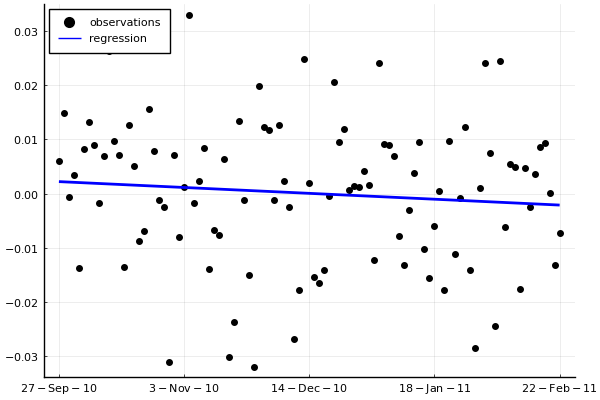

In [12]:
# Visualize observations
scatter(dates_num, stock_val, color="black", xticks=(xtick_points, [dates_str[i] for i in xtick_points]), label="observations", legend=:topleft)

# Overlay regression function
plot!(dates_num, regression_estimated, color="blue", label="regression", linewidth=2)

The slope coefficient $\theta_1$ is negative and the plot shows a decreasing line. The ISE experienced a negative linear trend from October 2010 up to March 2011. Assuming the stock market is an indicator of economic growth, then we may conclude that in March 2011 the Turkish economy is still in recession.

---

### $\ast$ **Try for yourself**

Change the `time period` variable. Re-run the regression and see how the results change.

---

### Recursive estimation

Our graph is quite large, which means our inference algorithm is slow. But as I already said earlier, the graph is essentially a repetition of the same structure. In this case, we don't need to generate such a large graph; we can _recursively_ estimate the classification parameters. To do this, we essentially estimate parameters for a single observation, and make the resulting posterior our prior for the next observation.

Let's first re-define the subgraph for a single observation.

In [13]:
# Start factor graph
graph = FactorGraph();

# Prior weight parameters
μ_θ = [0., 0.]
σ2_θ = [1. 0.; 0. 1.]

# Noise variance
σ2_Y = 1.

# Add weight prior to graph
@RV θ ~ GaussianMeanVariance(μ_θ, σ2_θ, id=:f_a)
    
# Define covariates
@RV X

# Define likelihood
@RV Y ~ GaussianMeanVariance(dot(θ,X), σ2_Y, id=:f_b)

# Designate observed variables
placeholder(X, :X, dims=(2,))
placeholder(Y, :Y)

# Visualise the graph
ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 3188621617390676127 -->
 
 3188621617390676127 
 
 clamp_1 
 
<!-- 16004998242306498114 -->
 
 16004998242306498114 
 
 placeholder_Y 
 
<!-- 12933985826999941881 -->
 
 12933985826999941881 
 
 𝒩 
 f_b 
 
<!-- 16004998242306498114--12933985826999941881 -->
 
 16004998242306498114--12933985826999941881 
 
 Y 
 1 out 
 1 out 
 
<!-- 17440655191997899150 -->
 
 17440655191997899150 
 
 𝒩 
 f_a 
 
<!-- 17440655191997899150--3188621617390676127 -->
 
 17440655191997899150--3188621617390676127 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 17962326440435339818 -->
 
 17962326440435339818 
 
 clamp_2 
 
<!-- 17440655191997899150--17962326440435339818 -->
 
 17440655191997899150--17962326440435339818 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 5010473153120996807 -->
 
 5010473153120996807 
 
 dot 
 dotproduct_1 
 
<!-- 12933985826999941881--5010473153120996807 -->
 
 12933985826999941881--5010473153120996807 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 7697078592879388377 -->
 
 7697078592879388377 
 
 clamp_3 
 
<!-- 12933985826999941881--7697078592879388377 -->
 
 12933985826999941881--7697078592879388377 
 
 clamp_3 
 1 out 
 3 v 
 
<!-- 5010473153120996807--17440655191997899150 -->
 
 5010473153120996807--17440655191997899150 
 
 θ 
 1 out 
 3 in2 
 
<!-- 3430118853939058773 -->
 
 3430118853939058773 
 
 placeholder_X 
 
<!-- 3430118853939058773--5010473153120996807 -->
 
 3430118853939058773--5010473153120996807 
 
 X 
 2 in1 
 1 out

In [14]:
# Define and compile the algorithm
algorithm = messagePassingAlgorithm(θ) 
source_code = algorithmSourceCode(algorithm)

# Evaluate the generated code to get the step! function
eval(Meta.parse(source_code));

The syntax for compiling the inference algorithm is the same as before, but now we execute it differently. We feed in each sample and perform a step update for the posterior.

In [15]:
# Initialize posteriors dictionary
posterior = Dict()

@showprogress for i = 1:num_samples
    
    # Load i-th data point
    data = Dict(:X => [dates_num[i], 1],
                :Y => stock_val[i])

    # Update posterior for θ
    step!(data, posterior)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


This is much faster. If we now visualize the resulting posterior, we see that it is not exactly the same. Recursive estimation is not mathematically equivalent to non-recursive estimation (it's the difference between filtering and smoothing, for those familiar). In this case, it produces a less sharply peaked posterior (note the y-axis between this plot and the previous posterior plot).

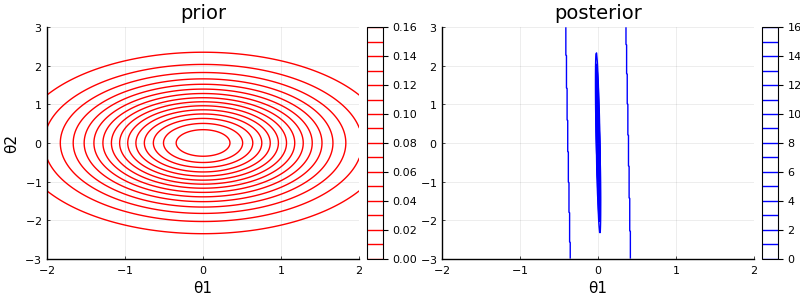

In [16]:
import ForneyLab: logPdf

# Define ranges for plot
x1 = range(-2, length=500, stop=2)
x2 = range(-3, length=500, stop=3)

# Draw contour plots of distributions
prior = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=μ_θ, v=σ2_θ)
p1a = contour(x1, x2, (x1,x2) -> exp(logPdf(prior, [x1,x2])), color="red", xlabel="θ1", ylabel="θ2", title="prior")
p1b = contour(x1, x2, (x1,x2) -> exp(logPdf(posterior[:θ], [x1,x2])), color="blue", xlabel="θ1", title="posterior")
plot(p1a, p1b, size=(800,300))

## Problem: Credit Assignment

We will now look at a classification problem. Suppose you are a bank and that you have to decide whether you will grant credit, e.g. a mortgage or a small business loan, to a customer. You have a historic data set where your experts have assigned credit to hundreds of people. You have asked them to report on what aspects of the problem are important. You hope to automate this decision process by training a classifier on the data set.

### Data

The data set we are going to use actually comes from the [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Credit+Approval). It consists of past credit assignments, labeled as successful (=1) or unsuccessful (=0). Many of the features have been anonymized for privacy concerns.

In [17]:
# Read CSV file
df = CSV.read("../datasets/credit_train.csv")

# Split dataframe into features and labels
features_train = convert(Array, df[:,1:7])
labels_train = convert(Array, df[:,8]);

# Store number of features
num_features = size(features_train,2)

# Number of training samples
num_train = size(features_train,1);

Let's visualize the data and see if we can make sense of it.

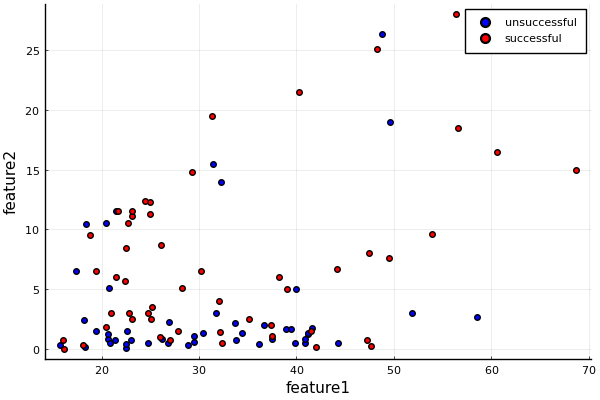

In [18]:
scatter(features_train[labels_train .== 0, 1], features_train[labels_train .== 0, 2], color="blue", label="unsuccessful", xlabel="feature1", ylabel="feature2")
scatter!(features_train[labels_train .== 1, 1], features_train[labels_train .== 1, 2], color="red", label="successful")

Mmhh, it doesn't look like the samples can easily be separated. This will be challenging.

---

### $\ast$ **Try for yourself**

The plot above shows features 1 and 2. Have a look at the other combinations of features.

---

### Model specification

We have features $X$, labels $Y$ and parameters $\theta$. Same as with regression, we are looking for a posterior distribution of the classification parameters:

$$\underbrace{p(\theta \mid Y, X)}_{\text{posterior}} \propto\ \underbrace{p(Y \mid X, \theta)}_{\text{likelihood}} \cdot \underbrace{p(\theta)}_{\text{prior}}$$

The likelihood in this case will be of a Logit form:

$$ p(Y \mid X, \theta) = \prod_{i=1}^{N} \ \text{Logit}(Y_i \mid f_\theta(X_i), \xi_i) \, .$$ 

A "Logit" is short for a Bernoulli distribution with a sigmoid transfer function: $ \sigma(x) = 1 / (1 + \exp(-x))$. The sigmoid maps the input to the interval $(0,1)$ so that the result acts as a rate parameter to the Bernoulli. Check Bert's lecture on discriminative classification for more information.

We are not using a Laplace approximation to the posterior, but rather a "local variational method" (see Section 10.5 of Bishop). We won't go into how that works here. All you need to know in this implementation is that there is a second parameter to the Logit, $\xi$ (the "local variational parameter"), which has to be estimated just as the classification parameters $\theta$ (but doesn't need a prior).

We will use a Gaussian prior distribution for the classification parameters $\theta$:

$$ p(\theta) = \mathcal{N}(\theta \mid \mu_\theta, \sigma^2_\theta) \, .$$

Note that the true posterior is still approximated with a Gaussian distribution.

In [19]:
import LinearAlgebra: I

In [20]:
# Start factor graph
graph = FactorGraph();

# Parameters for priors
μ_θ = zeros(num_features+1,)
σ2_θ = Matrix{Float64}(I, num_features+1, num_features+1)

# Define a prior over the weights
@RV θ ~ GaussianMeanVariance(μ_θ, σ2_θ)

X = Vector{Variable}(undef, num_train)
ξ = Vector{Variable}(undef, num_train)
Y = Vector{Variable}(undef, num_train)

for i = 1:num_train
    
    # Features
    @RV X[i]
    
    # Linear function
    @RV fθ = dot(θ, X[i])
    
    # Logit likelihood
    @RV ξ[i]
    @RV Y[i] ~ Logit(fθ, ξ[i])
    
    # Observed 
    placeholder(X[i], :X, index=i, dims=(num_features+1,))
    placeholder(Y[i], :Y, index=i)
    
end

We will now compile an inference algorithm for this model. Since we now have two unknown variables, $\theta$ and $\xi$, we need to define a `PosteriorFactorization()`. With this function, we are basically telling ForneyLab that these variables need to be estimated separately (i.e., generate two `step!` functions).

In [21]:
# We specify a recognition distribution
q = PosteriorFactorization(θ, ξ, ids=[:θ, :ξ])

# Define and compile the algorithm
algorithm = messagePassingAlgorithm() 
source_code = algorithmSourceCode(algorithm)

# Bring the generated source code into scope
eval(Meta.parse(source_code));

Now that we have compiled the algorithm, we are going to iteratively update the classification parameters and the local variational parameter.

In [22]:
# Initialize posteriors
posteriors = Dict()
for i = 1:num_train
    posteriors[:ξ_*i] = ProbabilityDistribution(Function, mode=1.0)
end

# Load data
data = Dict(:X => [[features_train[i,:]; 1] for i in 1:num_train],
            :Y => labels_train)

# Iterate updates
@showprogress for i = 1:10
    
    # Update classification parameters
    stepθ!(data, posteriors)
    
    # Update local variational parameters
    stepξ!(data, posteriors)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


### Predict test data

The bank has some test data for you as well. 

In [23]:
# Read CSV file
df = CSV.read("../datasets/credit_test.csv")

# Split dataframe into features and labels
features_test = convert(Array, df[:,1:7])
labels_test = convert(Array, df[:,8])

# Number of test samples
num_test = size(features_test,1);

You can classify test samples by taking the MAP for the classification parameters, computing the linear function $f_\theta$ and rounding the result to obtain the most probable label.

In [24]:
import ForneyLab: unsafeMode

In [25]:
# Extract MAP estimate of classification parameters
θ_MAP = unsafeMode(posteriors[:θ])

# Compute dot product between parameters and test data
fθ_pred = [features_test ones(num_test,)] * θ_MAP

# Predict labels
labels_pred = round.(1 ./(1 .+ exp.( -fθ_pred)));

# Compute classification accuracy of test data
accuracy_test = mean(labels_test .== labels_pred)

# Report result
println("Test Accuracy = "*string(accuracy_test*100)*"%")

Test Accuracy = 63.0%


Mmmhh... If you were a bank, you might decide that you don't want to automatically assign credit to your customers.